# Proyek Klasifikasi Gambar: [Food image dataset]
- **Nama:** Muhammad Rozagi
- **Email:** muhammadrozagi09@gmail.com
- **ID Dicoding:** rzgiii09

## Import Semua Packages/Library yang Digunakan

In [1]:
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

In [2]:
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadrozagi","key":"27d5beac07325810bea4cfb5045eee2f"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d imbikramsaha/food11

Dataset URL: https://www.kaggle.com/datasets/imbikramsaha/food11
License(s): CC0-1.0


In [6]:
!unzip food11.zip -d food11

Streaming output truncated to the last 5000 lines.
  inflating: food11/food11/train/hamburger/2722745.jpg  
  inflating: food11/food11/train/hamburger/272642.jpg  
  inflating: food11/food11/train/hamburger/2726558.jpg  
  inflating: food11/food11/train/hamburger/2738245.jpg  
  inflating: food11/food11/train/hamburger/2745577.jpg  
  inflating: food11/food11/train/hamburger/2745917.jpg  
  inflating: food11/food11/train/hamburger/2754513.jpg  
  inflating: food11/food11/train/hamburger/2756964.jpg  
  inflating: food11/food11/train/hamburger/2762170.jpg  
  inflating: food11/food11/train/hamburger/2766731.jpg  
  inflating: food11/food11/train/hamburger/2771605.jpg  
  inflating: food11/food11/train/hamburger/277584.jpg  
  inflating: food11/food11/train/hamburger/2777938.jpg  
  inflating: food11/food11/train/hamburger/2790429.jpg  
  inflating: food11/food11/train/hamburger/279510.jpg  
  inflating: food11/food11/train/hamburger/2797268.jpg  
  inflating: food11/food11/train/hamburg

In [7]:
# Direktori awal untuk train dan test
train_dir = "food11/food11/train"
test_dir = "food11/food11/test"

# Direktori baru untuk dataset gabungan
combined_dir = "food11/food11/dataset"

In [8]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [9]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

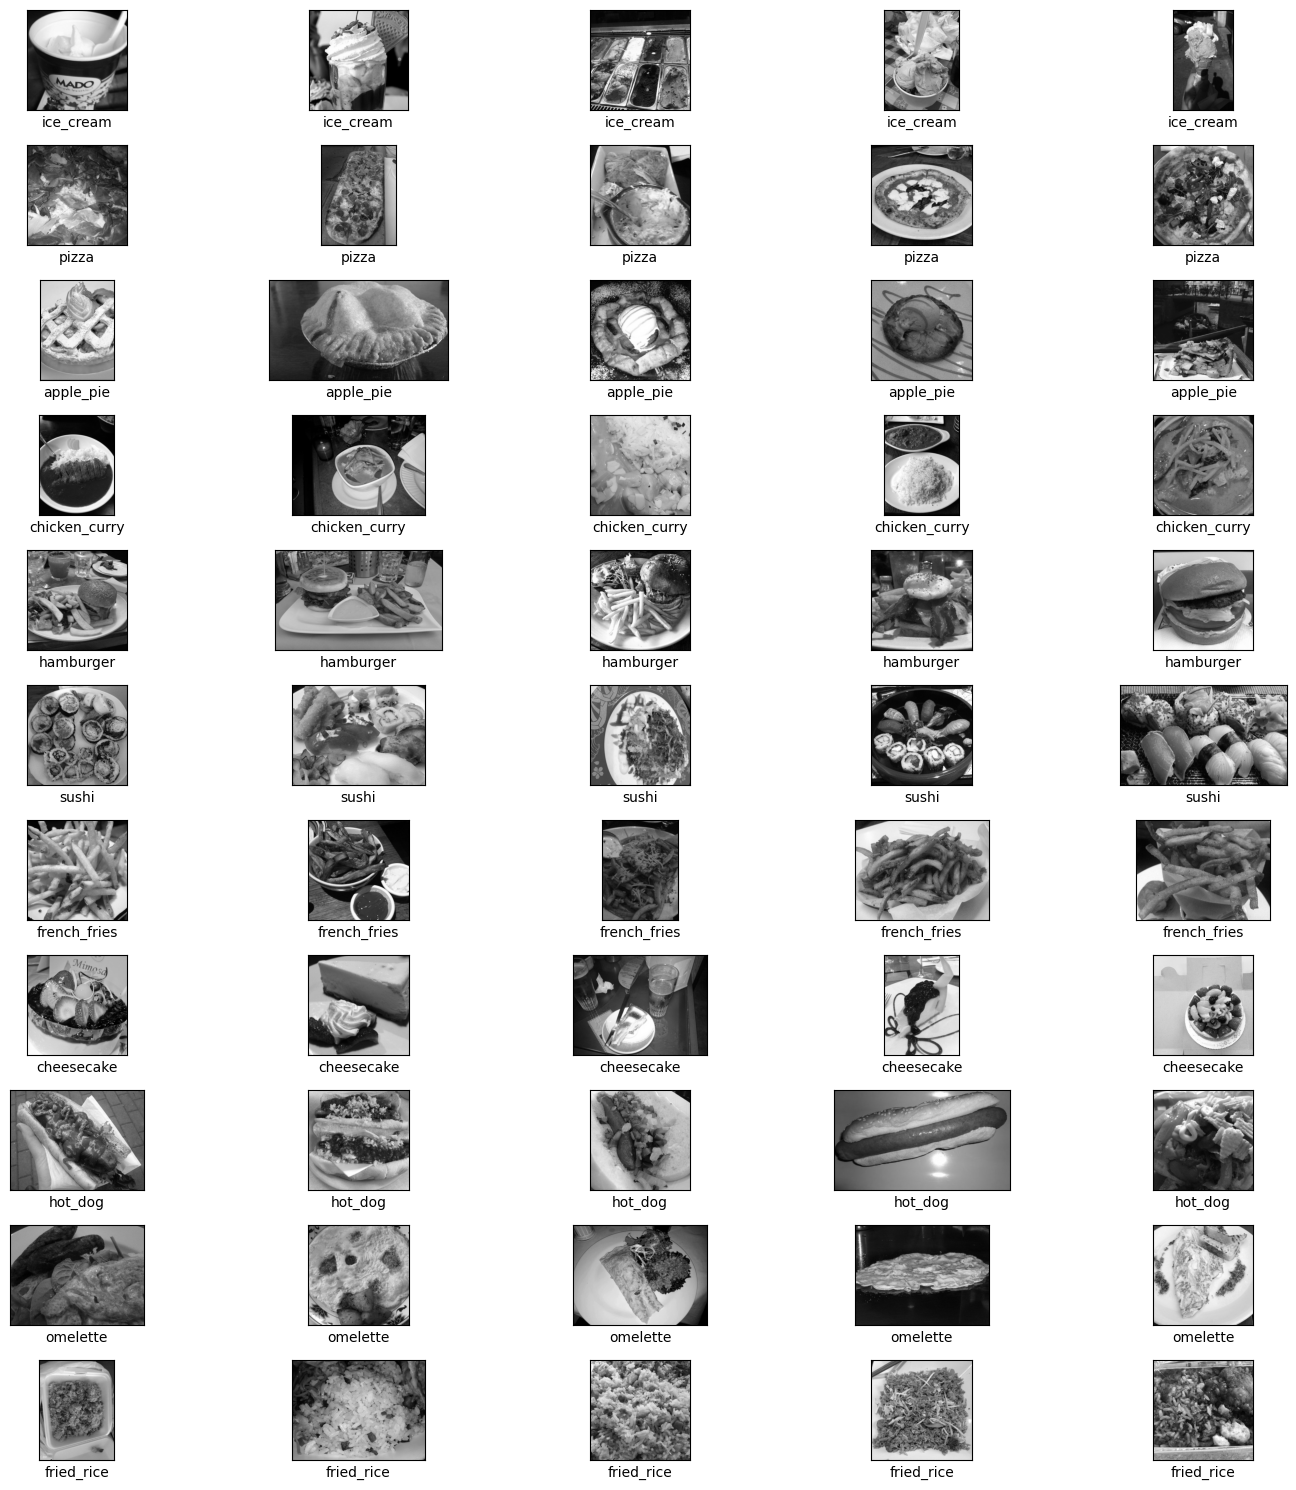

In [10]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
food_image = {}

# Tentukan path sumber train
path = "food11/food11/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    food_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "food11/food11/dataset/"

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(food_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(food_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

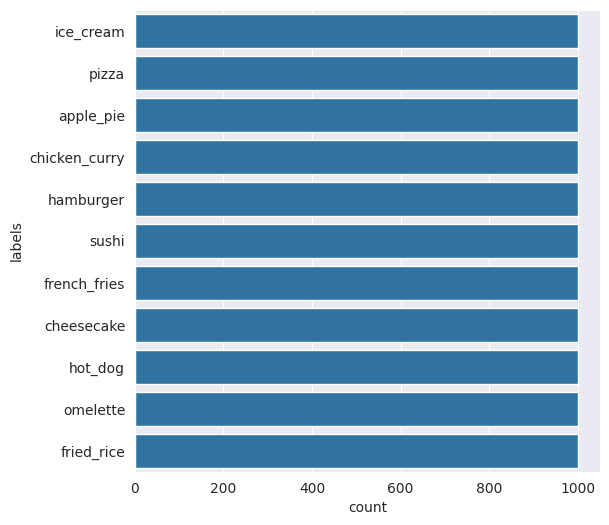

In [11]:
# Definisikan path sumber
food_path = "food11/food11/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(food_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [12]:
# Panggil variabel mypath yang menampung folder dataset gambar
mypath= 'food11/food11/dataset/'

file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
apple_pie,1000
cheesecake,1000
chicken_curry,1000
french_fries,1000
fried_rice,1000
hamburger,1000
hot_dog,1000
ice_cream,1000
omelette,1000


### Data Preprocessing

#### Split Dataset

In [13]:
# Bagi dataset menjadi train dan test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df['path'], df['labels'], test_size=0.2, random_state=300
)

# Bagi dataset train menjadi train dan validation (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=300
)

In [14]:
# Buat dataframe untuk train, validation, dan test
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_val = pd.DataFrame({'path': X_val, 'labels': y_val, 'set': 'validation'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

In [15]:
# Gabungkan dataframe
df_all = pd.concat([df_tr, df_val, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))

# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "food11/food11/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"


set         labels       
test        apple_pie        188
            cheesecake       187
            chicken_curry    166
            french_fries     216
            fried_rice       214
            hamburger        207
            hot_dog          207
            ice_cream        220
            omelette         214
            pizza            178
            sushi            203
train       apple_pie        636
            cheesecake       659
            chicken_curry    673
            french_fries     640
            fried_rice       615
            hamburger        660
            hot_dog          619
            ice_cream        618
            omelette         622
            pizza            657
            sushi            641
validation  apple_pie        176
            cheesecake       154
            chicken_curry    161
            french_fries     144
            fried_rice       171
            hamburger        133
            hot_dog          174
            ice_

In [16]:
from tqdm import tqdm # Import the tqdm function from the tqdm library

for index, row in tqdm(df_all.iterrows()): # Use tqdm instead of tq
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

11000it [00:03, 2823.54it/s]


In [17]:
# Definisikan direktori training, validation, dan test
TRAIN_DIR = "Dataset-Final/train/"
VAL_DIR = "Dataset-Final/validation/"  # Direktori validasi
TEST_DIR = "Dataset-Final/test/"

# Daftar semua kelas (kategori makanan)
food_classes = os.listdir(TRAIN_DIR)

# Loop untuk setiap kelas dan hitung jumlah gambar
for food_class in food_classes:
    train_path = os.path.join(TRAIN_DIR, food_class)
    val_path = os.path.join(VAL_DIR, food_class)  # Path validasi
    test_path = os.path.join(TEST_DIR, food_class)

    print(f"Total number of {food_class} images in training set: ", len(os.listdir(train_path)))
    print(f"Total number of {food_class} images in validation set: ", len(os.listdir(val_path)))  # Jumlah validasi
    print(f"Total number of {food_class} images in test set: ", len(os.listdir(test_path)))

Total number of ice_cream images in training set:  618
Total number of ice_cream images in validation set:  162
Total number of ice_cream images in test set:  220
Total number of pizza images in training set:  657
Total number of pizza images in validation set:  165
Total number of pizza images in test set:  178
Total number of apple_pie images in training set:  636
Total number of apple_pie images in validation set:  176
Total number of apple_pie images in test set:  188
Total number of chicken_curry images in training set:  673
Total number of chicken_curry images in validation set:  161
Total number of chicken_curry images in test set:  166
Total number of hamburger images in training set:  660
Total number of hamburger images in validation set:  133
Total number of hamburger images in test set:  207
Total number of sushi images in training set:  641
Total number of sushi images in validation set:  156
Total number of sushi images in test set:  203
Total number of french_fries image

In [18]:
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

im_shape = (299, 299)
BATCH_SIZE = 16
seed = 10

# Semua kelas yang ada di dataset
food_classes = os.listdir(TRAIN_DIR)


# Generator untuk data training
train_generator = data_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=im_shape,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=seed,
    classes=food_classes
)

# Generator untuk data validation
validation_generator = data_generator.flow_from_directory(
    VAL_DIR,  # Menggunakan direktori validasi
    target_size=im_shape,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed,
    classes=food_classes
)

# Generator untuk data test
test_generator = data_generator.flow_from_directory(
    TEST_DIR,
    target_size=im_shape,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    seed=seed,
    classes=food_classes
)

# Informasi data
nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples

classes = list(train_generator.class_indices.keys())
print('Classes: ' + str(classes))
num_classes = len(classes)


Found 7040 images belonging to 11 classes.
Found 1760 images belonging to 11 classes.
Found 2200 images belonging to 11 classes.
Classes: ['ice_cream', 'pizza', 'apple_pie', 'chicken_curry', 'hamburger', 'sushi', 'french_fries', 'cheesecake', 'hot_dog', 'omelette', 'fried_rice']


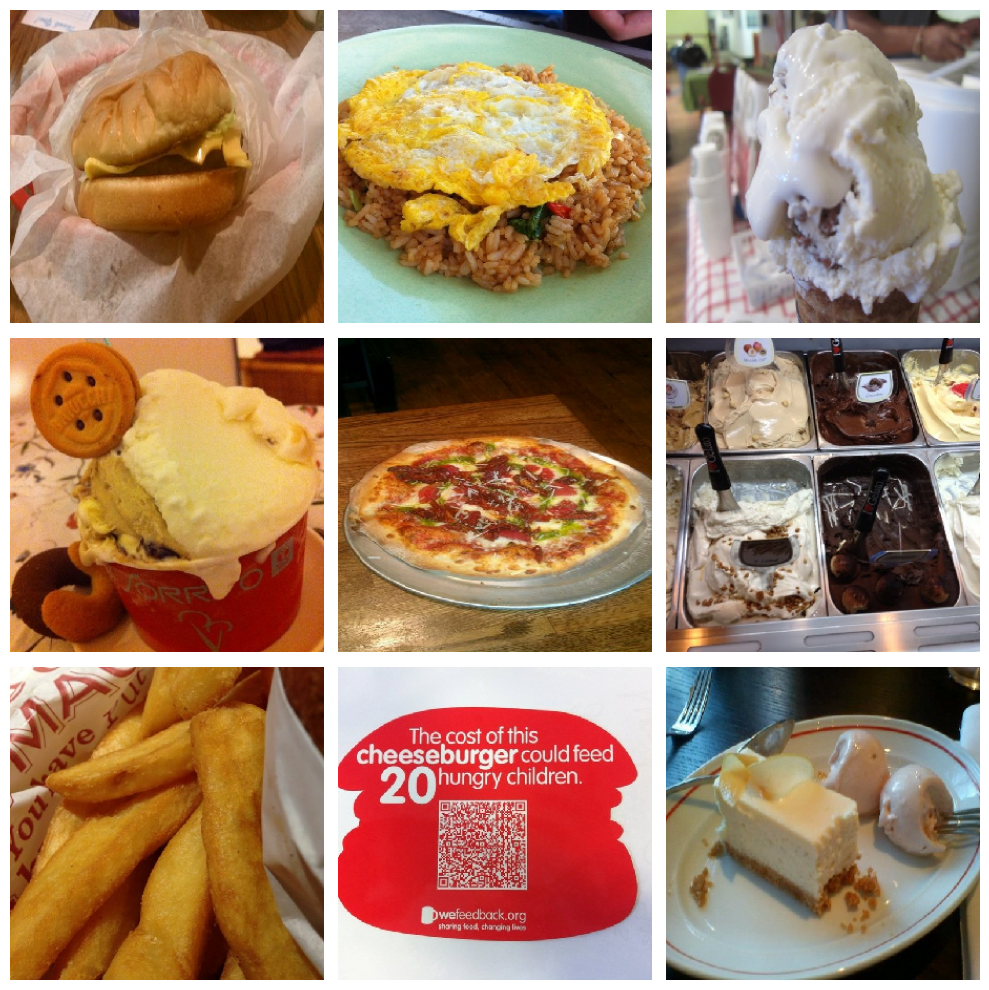

In [20]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    batch = next(train_generator)[0]
    image = ((batch[0] + 1) / 2 * 255).astype('uint8')
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()

## Modelling

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import InceptionV3
import tensorflow as tf

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # freeze base model

model = Sequential([
    base_model,

    # Tambahan Conv2D + Pooling biar memenuhi kriteria
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=(2, 2)),
    Dropout(0.3),  # Tambah dropout setelah Conv2D
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(11, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00009),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_94 (Conv2D)              │ (None, 8, 8, 64)       │     1,179,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,002,219 (87.75 MB)

 Trainable params: 1,199,307 (4.57 MB)

 Non-trainable params: 21,802,912 (83.17 MB)

In [22]:
class StopAtAccuracy(Callback):
    def __init__(self, threshold=0.95):
        super(StopAtAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.threshold and val_acc >= self.threshold:
                print(f"\n Akurasi mencapai {self.threshold*100:.0f}% pada train & val. Menghentikan training.")
                self.model.stop_training = True

In [23]:
stop_acc_callback = StopAtAccuracy(threshold=0.95)

In [24]:

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1,
        min_lr=1e-6
    ),
    stop_acc_callback
]

In [25]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks
)

Epoch 1/35


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


440/440 ━━━━━━━━━━━━━━━━━━━━ 76s 127ms/step - accuracy: 0.5869 - loss: 1.3738 - val_accuracy: 0.8233 - val_loss: 0.5906 - learning_rate: 9.0000e-05
Epoch 2/35
440/440 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - accuracy: 0.8048 - loss: 0.6600 - val_accuracy: 0.8290 - val_loss: 0.5588 - learning_rate: 9.0000e-05
Epoch 3/35
440/440 ━━━━━━━━━━━━━━━━━━━━ 39s 89ms/step - accuracy: 0.8527 - loss: 0.5098 - val_accuracy: 0.8426 - val_loss: 0.5333 - learning_rate: 9.0000e-05
Epoch 4/35
440/440 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.8822 - loss: 0.4105 - val_accuracy: 0.8227 - val_loss: 0.5371 - learning_rate: 9.0000e-05
Epoch 5/35
440/440 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accuracy: 0.8897 - loss: 0.3646 - val_accuracy: 0.8392 - val_loss: 0.5026 - learning_rate: 9.0000e-05
Epoch 6/35
440/440 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.9078 - loss: 0.3162 - val_accuracy: 0.8369 - val_loss: 0.5222 - learning_rate: 9.0000e-05
Epoch 7/35
440/440 ━━━━━━━━━━━━━━━━━━━━ 39s 88ms/step - accura

## Evaluasi dan Visualisasi

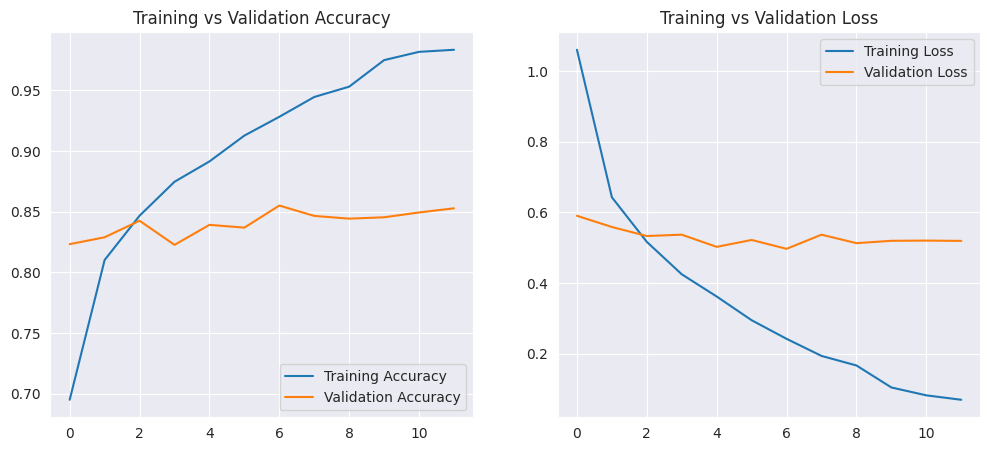

In [26]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')
plt.show()

In [27]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Akurasi Training Terakhir: {final_train_acc:.2%}")
print(f"Akurasi Validation Terakhir: {final_val_acc:.2%}")

Akurasi Training Terakhir: 98.35%
Akurasi Validation Terakhir: 85.28%


## Konversi Model

In [29]:
model.export('saved_model')

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='keras_tensor_311')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  139955065950032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139955065947344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139955065950992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139955065948304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139955065947152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139955065948112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139955065946192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139955065946576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139955065946960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139955067812752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13995506781294

In [30]:

converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Simpan ke file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [32]:

class_names = sorted(os.listdir(TRAIN_DIR))

with open("label.txt", "w") as f:
    for class_name in class_names:
        f.write(class_name + "\n")

print("label.txt dibuat")

label.txt dibuat


In [33]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [34]:

!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model/ tfjs_model/

2025-04-27 16:58:29.405421: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745773109.424998    5644 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745773109.430948    5644 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-27 16:58:36.044929: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745773116.045108    5644 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [35]:

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

os.makedirs('temp_model_dir', exist_ok=True)

# Pindahkan semua file dan folder ke folder sementara
shutil.move('model.tflite', 'temp_model_dir/model.tflite')
shutil.move('tfjs_model', 'temp_model_dir/tfjs_model')
shutil.move('saved_model', 'temp_model_dir/saved_model')
shutil.move('label.txt', 'temp_model_dir/label.txt')

Mounted at /content/drive


'temp_model_dir/label.txt'

In [36]:
drive_target = '/content/drive/MyDrive/Submission_Klasifikasi_Gambar'

# Hapus folder tujuan di Drive jika sudah ada, lalu salin
if os.path.exists(drive_target):
    shutil.rmtree(drive_target)
shutil.copytree('temp_model_dir', drive_target)

'/content/drive/MyDrive/Submission_Klasifikasi_Gambar'

## Inference (Optional)

In [37]:
import numpy as np

In [39]:
# Load model
interpreter = tf.lite.Interpreter(model_path="temp_model_dir/model.tflite") # Change the model path to reflect new location
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load label
with open("temp_model_dir/label.txt", "r") as f:  # Change the path to label.txt
    labels = [line.strip() for line in f.readlines()]

In [47]:
# Load
img = Image.open("testing_image1.jpeg")
img = img.resize((299, 299))
img = np.array(img, dtype=np.float32)
img = img / 255.0
img = np.expand_dims(img, axis=0)

interpreter.set_tensor(input_details[0]['index'], img)

# inferensi
interpreter.invoke()

# hasil
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

print(f"Predicted label: {labels[predicted_class]}")

Predicted label: apple_pie


In [42]:
# Load
img = Image.open("testing_image2.jpeg")
img = img.resize((299, 299))
img = np.array(img, dtype=np.float32)
img = img / 255.0
img = np.expand_dims(img, axis=0)

interpreter.set_tensor(input_details[0]['index'], img)

# inferensi
interpreter.invoke()

# hasil
output_data = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(output_data)

print(f"Predicted label: {labels[predicted_class]}")

Predicted label: fried_rice


In [57]:
!pip install pipreqs

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.3/798.3 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=3ab7c5f53d2158742b57cc85fb549b076bc59d47ced34ad071463023abf903d3
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
Successfully built docopt
  Attempting uninstall: ipython
    Found existing installation: ipython 7.34.0
    Uninstalling ipython-7.34.0:
      Successfully uninstalled ipython-7.34.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython==7.34.0, but you have ipython 8.12.3 which is incompatible.


In [59]:
!pipreqs "/content/drive/MyDrive/Colab Notebooks/Fix" --scan-notebooks

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in /content/drive/MyDrive/Colab Notebooks/Fix/requirements.txt
